# Nerfies Dataset Processing.

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook contains an example workflow for converting a video file to a Nerfies dataset.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a Nerfie using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb).


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power.
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately.
* Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

If you find this work useful, please consider citing:
```bibtex
@article{park2021nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Nerfies: Deformable Neural Radiance Fields},
  journal   = {ICCV},
  year      = {2021},
}
```

In [4]:
from pathlib import Path
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image
import pdb

## Configuration.

Mount Google Drive onto `/content/gdrive`. You can skip this if you want to run this locally.

In [10]:
# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name`. **Make sure you change this** when processing a new video.
capture_name = 'peopleInShade'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'input'
# Where to save mask images.
mask_dir = root_dir / 'mask'
mask_raw_dir = root_dir / 'groundtruth'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)
mask_dir.mkdir(exist_ok=True, parents=True)

FAKE_SINGLE_CAM = True

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
  mask_raw_dir = {mask_raw_dir}
  mask_dir = {mask_dir}
""")

Directories configured:
  root_dir = data/peopleInShade
  rgb_raw_dir = data/peopleInShade/input
  rgb_dir = data/peopleInShade/rgb
  colmap_dir = data/peopleInShade/colmap
  mask_raw_dir = data/peopleInShade/groundtruth
  mask_dir = data/peopleInShade/mask



## Dataset Processing.

### Load Video.

In this step we upload a video file and flatten it into PNG files using ffmpeg.

In [7]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.

tmp_rgb_raw_dir = rgb_raw_dir


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

for image_path in Path(tmp_rgb_raw_dir).glob('*.jpg'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))


Saving data/peopleInShade/rgb/1x/in001137.png
Saving data/peopleInShade/rgb/2x/in001137.png
Saving data/peopleInShade/rgb/1x/in000688.png
Saving data/peopleInShade/rgb/2x/in000688.png
Saving data/peopleInShade/rgb/1x/in000856.png
Saving data/peopleInShade/rgb/2x/in000856.png
Saving data/peopleInShade/rgb/1x/in000119.png
Saving data/peopleInShade/rgb/2x/in000119.png
Saving data/peopleInShade/rgb/1x/in000398.png
Saving data/peopleInShade/rgb/2x/in000398.png
Saving data/peopleInShade/rgb/1x/in000150.png
Saving data/peopleInShade/rgb/2x/in000150.png
Saving data/peopleInShade/rgb/1x/in000877.png
Saving data/peopleInShade/rgb/2x/in000877.png
Saving data/peopleInShade/rgb/1x/in000911.png
Saving data/peopleInShade/rgb/2x/in000911.png
Saving data/peopleInShade/rgb/1x/in000770.png
Saving data/peopleInShade/rgb/2x/in000770.png
Saving data/peopleInShade/rgb/1x/in000258.png
Saving data/peopleInShade/rgb/2x/in000258.png
Saving data/peopleInShade/rgb/1x/in000923.png
Saving data/peopleInShade/rgb/2x/i

Saving data/peopleInShade/rgb/2x/in000528.png
Saving data/peopleInShade/rgb/1x/in000207.png
Saving data/peopleInShade/rgb/2x/in000207.png
Saving data/peopleInShade/rgb/1x/in000521.png
Saving data/peopleInShade/rgb/2x/in000521.png
Saving data/peopleInShade/rgb/1x/in000967.png
Saving data/peopleInShade/rgb/2x/in000967.png
Saving data/peopleInShade/rgb/1x/in001127.png
Saving data/peopleInShade/rgb/2x/in001127.png
Saving data/peopleInShade/rgb/1x/in001103.png
Saving data/peopleInShade/rgb/2x/in001103.png
Saving data/peopleInShade/rgb/1x/in000816.png
Saving data/peopleInShade/rgb/2x/in000816.png
Saving data/peopleInShade/rgb/1x/in000701.png
Saving data/peopleInShade/rgb/2x/in000701.png
Saving data/peopleInShade/rgb/1x/in001187.png
Saving data/peopleInShade/rgb/2x/in001187.png
Saving data/peopleInShade/rgb/1x/in000448.png
Saving data/peopleInShade/rgb/2x/in000448.png
Saving data/peopleInShade/rgb/1x/in000320.png
Saving data/peopleInShade/rgb/2x/in000320.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000055.png
Saving data/peopleInShade/rgb/1x/in001141.png
Saving data/peopleInShade/rgb/2x/in001141.png
Saving data/peopleInShade/rgb/1x/in000640.png
Saving data/peopleInShade/rgb/2x/in000640.png
Saving data/peopleInShade/rgb/1x/in000226.png
Saving data/peopleInShade/rgb/2x/in000226.png
Saving data/peopleInShade/rgb/1x/in000581.png
Saving data/peopleInShade/rgb/2x/in000581.png
Saving data/peopleInShade/rgb/1x/in000683.png
Saving data/peopleInShade/rgb/2x/in000683.png
Saving data/peopleInShade/rgb/1x/in000650.png
Saving data/peopleInShade/rgb/2x/in000650.png
Saving data/peopleInShade/rgb/1x/in001036.png
Saving data/peopleInShade/rgb/2x/in001036.png
Saving data/peopleInShade/rgb/1x/in000506.png
Saving data/peopleInShade/rgb/2x/in000506.png
Saving data/peopleInShade/rgb/1x/in000343.png
Saving data/peopleInShade/rgb/2x/in000343.png
Saving data/peopleInShade/rgb/1x/in000161.png
Saving data/peopleInShade/rgb/2x/in000161.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000108.png
Saving data/peopleInShade/rgb/1x/in000263.png
Saving data/peopleInShade/rgb/2x/in000263.png
Saving data/peopleInShade/rgb/1x/in000753.png
Saving data/peopleInShade/rgb/2x/in000753.png
Saving data/peopleInShade/rgb/1x/in001158.png
Saving data/peopleInShade/rgb/2x/in001158.png
Saving data/peopleInShade/rgb/1x/in000077.png
Saving data/peopleInShade/rgb/2x/in000077.png
Saving data/peopleInShade/rgb/1x/in000333.png
Saving data/peopleInShade/rgb/2x/in000333.png
Saving data/peopleInShade/rgb/1x/in000167.png
Saving data/peopleInShade/rgb/2x/in000167.png
Saving data/peopleInShade/rgb/1x/in000710.png
Saving data/peopleInShade/rgb/2x/in000710.png
Saving data/peopleInShade/rgb/1x/in000649.png
Saving data/peopleInShade/rgb/2x/in000649.png
Saving data/peopleInShade/rgb/1x/in000134.png
Saving data/peopleInShade/rgb/2x/in000134.png
Saving data/peopleInShade/rgb/1x/in000757.png
Saving data/peopleInShade/rgb/2x/in000757.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000840.png
Saving data/peopleInShade/rgb/1x/in000036.png
Saving data/peopleInShade/rgb/2x/in000036.png
Saving data/peopleInShade/rgb/1x/in001160.png
Saving data/peopleInShade/rgb/2x/in001160.png
Saving data/peopleInShade/rgb/1x/in001106.png
Saving data/peopleInShade/rgb/2x/in001106.png
Saving data/peopleInShade/rgb/1x/in000748.png
Saving data/peopleInShade/rgb/2x/in000748.png
Saving data/peopleInShade/rgb/1x/in000406.png
Saving data/peopleInShade/rgb/2x/in000406.png
Saving data/peopleInShade/rgb/1x/in000191.png
Saving data/peopleInShade/rgb/2x/in000191.png
Saving data/peopleInShade/rgb/1x/in000434.png
Saving data/peopleInShade/rgb/2x/in000434.png
Saving data/peopleInShade/rgb/1x/in000850.png
Saving data/peopleInShade/rgb/2x/in000850.png
Saving data/peopleInShade/rgb/1x/in000666.png
Saving data/peopleInShade/rgb/2x/in000666.png
Saving data/peopleInShade/rgb/1x/in000682.png
Saving data/peopleInShade/rgb/2x/in000682.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000266.png
Saving data/peopleInShade/rgb/1x/in000147.png
Saving data/peopleInShade/rgb/2x/in000147.png
Saving data/peopleInShade/rgb/1x/in001168.png
Saving data/peopleInShade/rgb/2x/in001168.png
Saving data/peopleInShade/rgb/1x/in000936.png
Saving data/peopleInShade/rgb/2x/in000936.png
Saving data/peopleInShade/rgb/1x/in000611.png
Saving data/peopleInShade/rgb/2x/in000611.png
Saving data/peopleInShade/rgb/1x/in000773.png
Saving data/peopleInShade/rgb/2x/in000773.png
Saving data/peopleInShade/rgb/1x/in001011.png
Saving data/peopleInShade/rgb/2x/in001011.png
Saving data/peopleInShade/rgb/1x/in000185.png
Saving data/peopleInShade/rgb/2x/in000185.png
Saving data/peopleInShade/rgb/1x/in000268.png
Saving data/peopleInShade/rgb/2x/in000268.png
Saving data/peopleInShade/rgb/1x/in000854.png
Saving data/peopleInShade/rgb/2x/in000854.png
Saving data/peopleInShade/rgb/1x/in000938.png
Saving data/peopleInShade/rgb/2x/in000938.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000215.png
Saving data/peopleInShade/rgb/1x/in000559.png
Saving data/peopleInShade/rgb/2x/in000559.png
Saving data/peopleInShade/rgb/1x/in000843.png
Saving data/peopleInShade/rgb/2x/in000843.png
Saving data/peopleInShade/rgb/1x/in000691.png
Saving data/peopleInShade/rgb/2x/in000691.png
Saving data/peopleInShade/rgb/1x/in001054.png
Saving data/peopleInShade/rgb/2x/in001054.png
Saving data/peopleInShade/rgb/1x/in001089.png
Saving data/peopleInShade/rgb/2x/in001089.png
Saving data/peopleInShade/rgb/1x/in000498.png
Saving data/peopleInShade/rgb/2x/in000498.png
Saving data/peopleInShade/rgb/1x/in000336.png
Saving data/peopleInShade/rgb/2x/in000336.png
Saving data/peopleInShade/rgb/1x/in000265.png
Saving data/peopleInShade/rgb/2x/in000265.png
Saving data/peopleInShade/rgb/1x/in000534.png
Saving data/peopleInShade/rgb/2x/in000534.png
Saving data/peopleInShade/rgb/1x/in001112.png
Saving data/peopleInShade/rgb/2x/in001112.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000305.png
Saving data/peopleInShade/rgb/1x/in000304.png
Saving data/peopleInShade/rgb/2x/in000304.png
Saving data/peopleInShade/rgb/1x/in000743.png
Saving data/peopleInShade/rgb/2x/in000743.png
Saving data/peopleInShade/rgb/1x/in000889.png
Saving data/peopleInShade/rgb/2x/in000889.png
Saving data/peopleInShade/rgb/1x/in001040.png
Saving data/peopleInShade/rgb/2x/in001040.png
Saving data/peopleInShade/rgb/1x/in000397.png
Saving data/peopleInShade/rgb/2x/in000397.png
Saving data/peopleInShade/rgb/1x/in000508.png
Saving data/peopleInShade/rgb/2x/in000508.png
Saving data/peopleInShade/rgb/1x/in001008.png
Saving data/peopleInShade/rgb/2x/in001008.png
Saving data/peopleInShade/rgb/1x/in000223.png
Saving data/peopleInShade/rgb/2x/in000223.png
Saving data/peopleInShade/rgb/1x/in000749.png
Saving data/peopleInShade/rgb/2x/in000749.png
Saving data/peopleInShade/rgb/1x/in000563.png
Saving data/peopleInShade/rgb/2x/in000563.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000898.png
Saving data/peopleInShade/rgb/1x/in000567.png
Saving data/peopleInShade/rgb/2x/in000567.png
Saving data/peopleInShade/rgb/1x/in000240.png
Saving data/peopleInShade/rgb/2x/in000240.png
Saving data/peopleInShade/rgb/1x/in000029.png
Saving data/peopleInShade/rgb/2x/in000029.png
Saving data/peopleInShade/rgb/1x/in000580.png
Saving data/peopleInShade/rgb/2x/in000580.png
Saving data/peopleInShade/rgb/1x/in000512.png
Saving data/peopleInShade/rgb/2x/in000512.png
Saving data/peopleInShade/rgb/1x/in000278.png
Saving data/peopleInShade/rgb/2x/in000278.png
Saving data/peopleInShade/rgb/1x/in000636.png
Saving data/peopleInShade/rgb/2x/in000636.png
Saving data/peopleInShade/rgb/1x/in000205.png
Saving data/peopleInShade/rgb/2x/in000205.png
Saving data/peopleInShade/rgb/1x/in000541.png
Saving data/peopleInShade/rgb/2x/in000541.png
Saving data/peopleInShade/rgb/1x/in000673.png
Saving data/peopleInShade/rgb/2x/in000673.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000815.png
Saving data/peopleInShade/rgb/1x/in000021.png
Saving data/peopleInShade/rgb/2x/in000021.png
Saving data/peopleInShade/rgb/1x/in000902.png
Saving data/peopleInShade/rgb/2x/in000902.png
Saving data/peopleInShade/rgb/1x/in000997.png
Saving data/peopleInShade/rgb/2x/in000997.png
Saving data/peopleInShade/rgb/1x/in000509.png
Saving data/peopleInShade/rgb/2x/in000509.png
Saving data/peopleInShade/rgb/1x/in000054.png
Saving data/peopleInShade/rgb/2x/in000054.png
Saving data/peopleInShade/rgb/1x/in000922.png
Saving data/peopleInShade/rgb/2x/in000922.png
Saving data/peopleInShade/rgb/1x/in000451.png
Saving data/peopleInShade/rgb/2x/in000451.png
Saving data/peopleInShade/rgb/1x/in001196.png
Saving data/peopleInShade/rgb/2x/in001196.png
Saving data/peopleInShade/rgb/1x/in000100.png
Saving data/peopleInShade/rgb/2x/in000100.png
Saving data/peopleInShade/rgb/1x/in000619.png
Saving data/peopleInShade/rgb/2x/in000619.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000676.png
Saving data/peopleInShade/rgb/1x/in000971.png
Saving data/peopleInShade/rgb/2x/in000971.png
Saving data/peopleInShade/rgb/1x/in000752.png
Saving data/peopleInShade/rgb/2x/in000752.png
Saving data/peopleInShade/rgb/1x/in000484.png
Saving data/peopleInShade/rgb/2x/in000484.png
Saving data/peopleInShade/rgb/1x/in001114.png
Saving data/peopleInShade/rgb/2x/in001114.png
Saving data/peopleInShade/rgb/1x/in000547.png
Saving data/peopleInShade/rgb/2x/in000547.png
Saving data/peopleInShade/rgb/1x/in000162.png
Saving data/peopleInShade/rgb/2x/in000162.png
Saving data/peopleInShade/rgb/1x/in000903.png
Saving data/peopleInShade/rgb/2x/in000903.png
Saving data/peopleInShade/rgb/1x/in000745.png
Saving data/peopleInShade/rgb/2x/in000745.png
Saving data/peopleInShade/rgb/1x/in000111.png
Saving data/peopleInShade/rgb/2x/in000111.png
Saving data/peopleInShade/rgb/1x/in000974.png
Saving data/peopleInShade/rgb/2x/in000974.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in001001.png
Saving data/peopleInShade/rgb/1x/in000805.png
Saving data/peopleInShade/rgb/2x/in000805.png
Saving data/peopleInShade/rgb/1x/in000300.png
Saving data/peopleInShade/rgb/2x/in000300.png
Saving data/peopleInShade/rgb/1x/in000870.png
Saving data/peopleInShade/rgb/2x/in000870.png
Saving data/peopleInShade/rgb/1x/in001170.png
Saving data/peopleInShade/rgb/2x/in001170.png
Saving data/peopleInShade/rgb/1x/in000671.png
Saving data/peopleInShade/rgb/2x/in000671.png
Saving data/peopleInShade/rgb/1x/in000991.png
Saving data/peopleInShade/rgb/2x/in000991.png
Saving data/peopleInShade/rgb/1x/in000551.png
Saving data/peopleInShade/rgb/2x/in000551.png
Saving data/peopleInShade/rgb/1x/in000381.png
Saving data/peopleInShade/rgb/2x/in000381.png
Saving data/peopleInShade/rgb/1x/in000882.png
Saving data/peopleInShade/rgb/2x/in000882.png
Saving data/peopleInShade/rgb/1x/in000339.png
Saving data/peopleInShade/rgb/2x/in000339.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in000704.png
Saving data/peopleInShade/rgb/1x/in001191.png
Saving data/peopleInShade/rgb/2x/in001191.png
Saving data/peopleInShade/rgb/1x/in000145.png
Saving data/peopleInShade/rgb/2x/in000145.png
Saving data/peopleInShade/rgb/1x/in000120.png
Saving data/peopleInShade/rgb/2x/in000120.png
Saving data/peopleInShade/rgb/1x/in000358.png
Saving data/peopleInShade/rgb/2x/in000358.png
Saving data/peopleInShade/rgb/1x/in000774.png
Saving data/peopleInShade/rgb/2x/in000774.png
Saving data/peopleInShade/rgb/1x/in000592.png
Saving data/peopleInShade/rgb/2x/in000592.png
Saving data/peopleInShade/rgb/1x/in000212.png
Saving data/peopleInShade/rgb/2x/in000212.png
Saving data/peopleInShade/rgb/1x/in000122.png
Saving data/peopleInShade/rgb/2x/in000122.png
Saving data/peopleInShade/rgb/1x/in000849.png
Saving data/peopleInShade/rgb/2x/in000849.png
Saving data/peopleInShade/rgb/1x/in001189.png
Saving data/peopleInShade/rgb/2x/in001189.png
Saving data/peopleInShade/rgb/1x/i

Saving data/peopleInShade/rgb/2x/in001061.png
Saving data/peopleInShade/rgb/1x/in000186.png
Saving data/peopleInShade/rgb/2x/in000186.png
Saving data/peopleInShade/rgb/1x/in000584.png
Saving data/peopleInShade/rgb/2x/in000584.png
Saving data/peopleInShade/rgb/1x/in000906.png
Saving data/peopleInShade/rgb/2x/in000906.png
Saving data/peopleInShade/rgb/1x/in001113.png
Saving data/peopleInShade/rgb/2x/in001113.png
Saving data/peopleInShade/rgb/1x/in000633.png
Saving data/peopleInShade/rgb/2x/in000633.png
Saving data/peopleInShade/rgb/1x/in001030.png
Saving data/peopleInShade/rgb/2x/in001030.png
Saving data/peopleInShade/rgb/1x/in000262.png
Saving data/peopleInShade/rgb/2x/in000262.png
Saving data/peopleInShade/rgb/1x/in000823.png
Saving data/peopleInShade/rgb/2x/in000823.png
Saving data/peopleInShade/rgb/1x/in000502.png
Saving data/peopleInShade/rgb/2x/in000502.png
Saving data/peopleInShade/rgb/1x/in000810.png
Saving data/peopleInShade/rgb/2x/in000810.png
Saving data/peopleInShade/rgb/1x/i

### Do the same for mask

In [8]:
if mask_raw_dir.exists():
    for mask_path in Path(mask_raw_dir).glob('*.png'):
      mask = make_divisible(imageio.imread(mask_path), max(image_scales))
      for scale in image_scales:
        save_image(
            mask_dir / f"{scale}x/{mask_path.stem.replace('segmentation','rgba')}.png",
            image_to_uint8(downsample_image(mask, scale)))

Saving data/peopleInShade/mask/1x/gt001113.png
Saving data/peopleInShade/mask/2x/gt001113.png
Saving data/peopleInShade/mask/1x/gt000152.png
Saving data/peopleInShade/mask/2x/gt000152.png
Saving data/peopleInShade/mask/1x/gt001171.png
Saving data/peopleInShade/mask/2x/gt001171.png
Saving data/peopleInShade/mask/1x/gt000701.png
Saving data/peopleInShade/mask/2x/gt000701.png
Saving data/peopleInShade/mask/1x/gt000386.png
Saving data/peopleInShade/mask/2x/gt000386.png
Saving data/peopleInShade/mask/1x/gt000605.png
Saving data/peopleInShade/mask/2x/gt000605.png
Saving data/peopleInShade/mask/1x/gt001169.png
Saving data/peopleInShade/mask/2x/gt001169.png
Saving data/peopleInShade/mask/1x/gt000577.png
Saving data/peopleInShade/mask/2x/gt000577.png
Saving data/peopleInShade/mask/1x/gt001154.png
Saving data/peopleInShade/mask/2x/gt001154.png
Saving data/peopleInShade/mask/1x/gt000631.png
Saving data/peopleInShade/mask/2x/gt000631.png
Saving data/peopleInShade/mask/1x/gt000185.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt001082.png
Saving data/peopleInShade/mask/2x/gt001082.png
Saving data/peopleInShade/mask/1x/gt000402.png
Saving data/peopleInShade/mask/2x/gt000402.png
Saving data/peopleInShade/mask/1x/gt001014.png
Saving data/peopleInShade/mask/2x/gt001014.png
Saving data/peopleInShade/mask/1x/gt000242.png
Saving data/peopleInShade/mask/2x/gt000242.png
Saving data/peopleInShade/mask/1x/gt001164.png
Saving data/peopleInShade/mask/2x/gt001164.png
Saving data/peopleInShade/mask/1x/gt000620.png
Saving data/peopleInShade/mask/2x/gt000620.png
Saving data/peopleInShade/mask/1x/gt000785.png
Saving data/peopleInShade/mask/2x/gt000785.png
Saving data/peopleInShade/mask/1x/gt000503.png
Saving data/peopleInShade/mask/2x/gt000503.png
Saving data/peopleInShade/mask/1x/gt000908.png
Saving data/peopleInShade/mask/2x/gt000908.png
Saving data/peopleInShade/mask/1x/gt000567.png
Saving data/peopleInShade/mask/2x/gt000567.png
Saving data/peopleInShade/mask/1x/gt000602.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000085.png
Saving data/peopleInShade/mask/2x/gt000085.png
Saving data/peopleInShade/mask/1x/gt000366.png
Saving data/peopleInShade/mask/2x/gt000366.png
Saving data/peopleInShade/mask/1x/gt000228.png
Saving data/peopleInShade/mask/2x/gt000228.png
Saving data/peopleInShade/mask/1x/gt000502.png
Saving data/peopleInShade/mask/2x/gt000502.png
Saving data/peopleInShade/mask/1x/gt000296.png
Saving data/peopleInShade/mask/2x/gt000296.png
Saving data/peopleInShade/mask/1x/gt000034.png
Saving data/peopleInShade/mask/2x/gt000034.png
Saving data/peopleInShade/mask/1x/gt000769.png
Saving data/peopleInShade/mask/2x/gt000769.png
Saving data/peopleInShade/mask/1x/gt000294.png
Saving data/peopleInShade/mask/2x/gt000294.png
Saving data/peopleInShade/mask/1x/gt001161.png
Saving data/peopleInShade/mask/2x/gt001161.png
Saving data/peopleInShade/mask/1x/gt000572.png
Saving data/peopleInShade/mask/2x/gt000572.png
Saving data/peopleInShade/mask/1x/gt000518.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000210.png
Saving data/peopleInShade/mask/2x/gt000210.png
Saving data/peopleInShade/mask/1x/gt000808.png
Saving data/peopleInShade/mask/2x/gt000808.png
Saving data/peopleInShade/mask/1x/gt000696.png
Saving data/peopleInShade/mask/2x/gt000696.png
Saving data/peopleInShade/mask/1x/gt000151.png
Saving data/peopleInShade/mask/2x/gt000151.png
Saving data/peopleInShade/mask/1x/gt001071.png
Saving data/peopleInShade/mask/2x/gt001071.png
Saving data/peopleInShade/mask/1x/gt000843.png
Saving data/peopleInShade/mask/2x/gt000843.png
Saving data/peopleInShade/mask/1x/gt001191.png
Saving data/peopleInShade/mask/2x/gt001191.png
Saving data/peopleInShade/mask/1x/gt001116.png
Saving data/peopleInShade/mask/2x/gt001116.png
Saving data/peopleInShade/mask/1x/gt000750.png
Saving data/peopleInShade/mask/2x/gt000750.png
Saving data/peopleInShade/mask/1x/gt001192.png
Saving data/peopleInShade/mask/2x/gt001192.png
Saving data/peopleInShade/mask/1x/gt000645.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000712.png
Saving data/peopleInShade/mask/1x/gt000149.png
Saving data/peopleInShade/mask/2x/gt000149.png
Saving data/peopleInShade/mask/1x/gt000512.png
Saving data/peopleInShade/mask/2x/gt000512.png
Saving data/peopleInShade/mask/1x/gt000473.png
Saving data/peopleInShade/mask/2x/gt000473.png
Saving data/peopleInShade/mask/1x/gt000403.png
Saving data/peopleInShade/mask/2x/gt000403.png
Saving data/peopleInShade/mask/1x/gt000007.png
Saving data/peopleInShade/mask/2x/gt000007.png
Saving data/peopleInShade/mask/1x/gt000863.png
Saving data/peopleInShade/mask/2x/gt000863.png
Saving data/peopleInShade/mask/1x/gt000623.png
Saving data/peopleInShade/mask/2x/gt000623.png
Saving data/peopleInShade/mask/1x/gt000157.png
Saving data/peopleInShade/mask/2x/gt000157.png
Saving data/peopleInShade/mask/1x/gt001091.png
Saving data/peopleInShade/mask/2x/gt001091.png
Saving data/peopleInShade/mask/1x/gt000612.png
Saving data/peopleInShade/mask/2x/gt000612.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt001104.png
Saving data/peopleInShade/mask/2x/gt001104.png
Saving data/peopleInShade/mask/1x/gt000428.png
Saving data/peopleInShade/mask/2x/gt000428.png
Saving data/peopleInShade/mask/1x/gt000774.png
Saving data/peopleInShade/mask/2x/gt000774.png
Saving data/peopleInShade/mask/1x/gt000551.png
Saving data/peopleInShade/mask/2x/gt000551.png
Saving data/peopleInShade/mask/1x/gt000944.png
Saving data/peopleInShade/mask/2x/gt000944.png
Saving data/peopleInShade/mask/1x/gt000206.png
Saving data/peopleInShade/mask/2x/gt000206.png
Saving data/peopleInShade/mask/1x/gt000949.png
Saving data/peopleInShade/mask/2x/gt000949.png
Saving data/peopleInShade/mask/1x/gt000718.png
Saving data/peopleInShade/mask/2x/gt000718.png
Saving data/peopleInShade/mask/1x/gt000132.png
Saving data/peopleInShade/mask/2x/gt000132.png
Saving data/peopleInShade/mask/1x/gt001024.png
Saving data/peopleInShade/mask/2x/gt001024.png
Saving data/peopleInShade/mask/1x/gt000437.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000068.png
Saving data/peopleInShade/mask/2x/gt000068.png
Saving data/peopleInShade/mask/1x/gt000406.png
Saving data/peopleInShade/mask/2x/gt000406.png
Saving data/peopleInShade/mask/1x/gt001045.png
Saving data/peopleInShade/mask/2x/gt001045.png
Saving data/peopleInShade/mask/1x/gt000882.png
Saving data/peopleInShade/mask/2x/gt000882.png
Saving data/peopleInShade/mask/1x/gt001115.png
Saving data/peopleInShade/mask/2x/gt001115.png
Saving data/peopleInShade/mask/1x/gt000507.png
Saving data/peopleInShade/mask/2x/gt000507.png
Saving data/peopleInShade/mask/1x/gt000821.png
Saving data/peopleInShade/mask/2x/gt000821.png
Saving data/peopleInShade/mask/1x/gt000830.png
Saving data/peopleInShade/mask/2x/gt000830.png
Saving data/peopleInShade/mask/1x/gt001098.png
Saving data/peopleInShade/mask/2x/gt001098.png
Saving data/peopleInShade/mask/1x/gt001025.png
Saving data/peopleInShade/mask/2x/gt001025.png
Saving data/peopleInShade/mask/1x/gt000616.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000430.png
Saving data/peopleInShade/mask/1x/gt000425.png
Saving data/peopleInShade/mask/2x/gt000425.png
Saving data/peopleInShade/mask/1x/gt000029.png
Saving data/peopleInShade/mask/2x/gt000029.png
Saving data/peopleInShade/mask/1x/gt000205.png
Saving data/peopleInShade/mask/2x/gt000205.png
Saving data/peopleInShade/mask/1x/gt000159.png
Saving data/peopleInShade/mask/2x/gt000159.png
Saving data/peopleInShade/mask/1x/gt000962.png
Saving data/peopleInShade/mask/2x/gt000962.png
Saving data/peopleInShade/mask/1x/gt000463.png
Saving data/peopleInShade/mask/2x/gt000463.png
Saving data/peopleInShade/mask/1x/gt000704.png
Saving data/peopleInShade/mask/2x/gt000704.png
Saving data/peopleInShade/mask/1x/gt000482.png
Saving data/peopleInShade/mask/2x/gt000482.png
Saving data/peopleInShade/mask/1x/gt000657.png
Saving data/peopleInShade/mask/2x/gt000657.png
Saving data/peopleInShade/mask/1x/gt000993.png
Saving data/peopleInShade/mask/2x/gt000993.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000756.png
Saving data/peopleInShade/mask/1x/gt001159.png
Saving data/peopleInShade/mask/2x/gt001159.png
Saving data/peopleInShade/mask/1x/gt000970.png
Saving data/peopleInShade/mask/2x/gt000970.png
Saving data/peopleInShade/mask/1x/gt000220.png
Saving data/peopleInShade/mask/2x/gt000220.png
Saving data/peopleInShade/mask/1x/gt000838.png
Saving data/peopleInShade/mask/2x/gt000838.png
Saving data/peopleInShade/mask/1x/gt000942.png
Saving data/peopleInShade/mask/2x/gt000942.png
Saving data/peopleInShade/mask/1x/gt000890.png
Saving data/peopleInShade/mask/2x/gt000890.png
Saving data/peopleInShade/mask/1x/gt000429.png
Saving data/peopleInShade/mask/2x/gt000429.png
Saving data/peopleInShade/mask/1x/gt000635.png
Saving data/peopleInShade/mask/2x/gt000635.png
Saving data/peopleInShade/mask/1x/gt000278.png
Saving data/peopleInShade/mask/2x/gt000278.png
Saving data/peopleInShade/mask/1x/gt000934.png
Saving data/peopleInShade/mask/2x/gt000934.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000448.png
Saving data/peopleInShade/mask/2x/gt000448.png
Saving data/peopleInShade/mask/1x/gt000539.png
Saving data/peopleInShade/mask/2x/gt000539.png
Saving data/peopleInShade/mask/1x/gt000264.png
Saving data/peopleInShade/mask/2x/gt000264.png
Saving data/peopleInShade/mask/1x/gt000606.png
Saving data/peopleInShade/mask/2x/gt000606.png
Saving data/peopleInShade/mask/1x/gt000875.png
Saving data/peopleInShade/mask/2x/gt000875.png
Saving data/peopleInShade/mask/1x/gt001031.png
Saving data/peopleInShade/mask/2x/gt001031.png
Saving data/peopleInShade/mask/1x/gt000238.png
Saving data/peopleInShade/mask/2x/gt000238.png
Saving data/peopleInShade/mask/1x/gt000716.png
Saving data/peopleInShade/mask/2x/gt000716.png
Saving data/peopleInShade/mask/1x/gt000270.png
Saving data/peopleInShade/mask/2x/gt000270.png
Saving data/peopleInShade/mask/1x/gt000767.png
Saving data/peopleInShade/mask/2x/gt000767.png
Saving data/peopleInShade/mask/1x/gt000592.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000881.png
Saving data/peopleInShade/mask/2x/gt000881.png
Saving data/peopleInShade/mask/1x/gt001184.png
Saving data/peopleInShade/mask/2x/gt001184.png
Saving data/peopleInShade/mask/1x/gt000538.png
Saving data/peopleInShade/mask/2x/gt000538.png
Saving data/peopleInShade/mask/1x/gt000477.png
Saving data/peopleInShade/mask/2x/gt000477.png
Saving data/peopleInShade/mask/1x/gt001128.png
Saving data/peopleInShade/mask/2x/gt001128.png
Saving data/peopleInShade/mask/1x/gt000755.png
Saving data/peopleInShade/mask/2x/gt000755.png
Saving data/peopleInShade/mask/1x/gt000204.png
Saving data/peopleInShade/mask/2x/gt000204.png
Saving data/peopleInShade/mask/1x/gt000906.png
Saving data/peopleInShade/mask/2x/gt000906.png
Saving data/peopleInShade/mask/1x/gt000892.png
Saving data/peopleInShade/mask/2x/gt000892.png
Saving data/peopleInShade/mask/1x/gt001139.png
Saving data/peopleInShade/mask/2x/gt001139.png
Saving data/peopleInShade/mask/1x/gt001174.png
Saving data/p

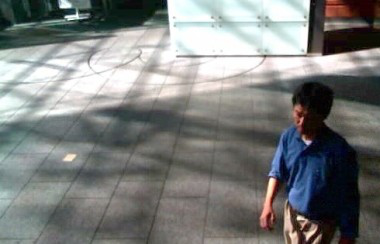

In [9]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

In [9]:
colmap_image_scale = 1  # @param {type: 'number'}

### Camera registration with COLMAP.

In [10]:
# @title Extract features.
# @markdown Computes SIFT features and saves them to the COLMAP DB.
share_intrinsics = True  # @param {type: 'boolean'}
assume_upright_cameras = True  # @param {type: 'boolean'}

# @markdown This sets the scale at which we will run COLMAP. A scale of 1 will be more accurate but will be slow.
colmap_rgb_dir = rgb_dir / f'{colmap_image_scale}x'

# @markdown Check this if you want to re-process SfM.
overwrite = True  # @param {type: 'boolean'}

if overwrite and colmap_db_path.exists():
  colmap_db_path.unlink()

!colmap feature_extractor \
--SiftExtraction.use_gpu 0 \
--SiftExtraction.upright {int(assume_upright_cameras)} \
--ImageReader.camera_model OPENCV \
--ImageReader.single_camera {int(share_intrinsics)} \
--database_path "{str(colmap_db_path)}" \
--image_path "{str(colmap_rgb_dir)}"


Feature extraction

Processed file [1/1570]
  Name:            in000003.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        965
Processed file [2/1570]
  Name:            in000004.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        1009
Processed file [3/1570]
  Name:            in000005.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        972
Processed file [4/1570]
  Name:            in000006.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        940
Processed file [5/1570]
  Name:            in000002.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        1025
Processed file [6/1570]
  Name:            in000001.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00p

Processed file [50/1570]
  Name:            in000051.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        638
Processed file [51/1570]
  Name:            in000057.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        879
Processed file [52/1570]
  Name:            in000052.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        619
Processed file [53/1570]
  Name:            in000056.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        379
Processed file [54/1570]
  Name:            in000055.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        549
Processed file [55/1570]
  Name:            in000053.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:    

Processed file [100/1570]
  Name:            in000099.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        293
Processed file [101/1570]
  Name:            in000104.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        317
Processed file [102/1570]
  Name:            in000102.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        339
Processed file [103/1570]
  Name:            in000098.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        257
Processed file [104/1570]
  Name:            in000103.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        261
Processed file [105/1570]
  Name:            in000105.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [150/1570]
  Name:            in000152.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        150
Processed file [151/1570]
  Name:            in000149.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        494
Processed file [152/1570]
  Name:            in000148.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        743
Processed file [153/1570]
  Name:            in000153.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        225
Processed file [154/1570]
  Name:            in000154.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        295
Processed file [155/1570]
  Name:            in000155.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [200/1570]
  Name:            in000201.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        246
Processed file [201/1570]
  Name:            in000202.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        226
Processed file [202/1570]
  Name:            in000200.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        418
Processed file [203/1570]
  Name:            in000203.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        179
Processed file [204/1570]
  Name:            in000204.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        303
Processed file [205/1570]
  Name:            in000206.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [249/1570]
  Name:            in000248.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        690
Processed file [250/1570]
  Name:            in000250.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        450
Processed file [251/1570]
  Name:            in000251.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        501
Processed file [252/1570]
  Name:            in000253.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        371
Processed file [253/1570]
  Name:            in000252.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        537
Processed file [254/1570]
  Name:            in000257.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

  Features:        801
Processed file [300/1570]
  Name:            in000301.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        793
Processed file [301/1570]
  Name:            in000297.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        785
Processed file [302/1570]
  Name:            in000302.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        813
Processed file [303/1570]
  Name:            in000304.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        782
Processed file [304/1570]
  Name:            in000303.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        847
Processed file [305/1570]
  Name:            in000306.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length

Processed file [349/1570]
  Name:            in000349.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        663
Processed file [350/1570]
  Name:            in000352.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        476
Processed file [351/1570]
  Name:            in000351.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        768
Processed file [352/1570]
  Name:            in000350.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        675
Processed file [353/1570]
  Name:            in000357.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        411
Processed file [354/1570]
  Name:            in000355.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [398/1570]
  Name:            in000400.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        372
Processed file [399/1570]
  Name:            in000399.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        497
Processed file [400/1570]
  Name:            in000401.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        283
Processed file [401/1570]
  Name:            in000402.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        338
Processed file [402/1570]
  Name:            in000398.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        636
Processed file [403/1570]
  Name:            in000403.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [447/1570]
  Name:            in000447.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        236
Processed file [448/1570]
  Name:            in000449.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        249
Processed file [449/1570]
  Name:            in000450.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        261
Processed file [450/1570]
  Name:            in000448.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        399
Processed file [451/1570]
  Name:            in000452.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        288
Processed file [452/1570]
  Name:            in000451.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [497/1570]
  Name:            in000497.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        276
Processed file [498/1570]
  Name:            in000498.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        184
Processed file [499/1570]
  Name:            in000499.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        239
Processed file [500/1570]
  Name:            in000500.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        258
Processed file [501/1570]
  Name:            in000502.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        261
Processed file [502/1570]
  Name:            in000506.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [546/1570]
  Name:            in000545.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        370
Processed file [547/1570]
  Name:            in000547.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        361
Processed file [548/1570]
  Name:            in000550.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        188
Processed file [549/1570]
  Name:            in000549.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        326
Processed file [550/1570]
  Name:            in000548.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        314
Processed file [551/1570]
  Name:            in000552.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [596/1570]
  Name:            in000594.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        840
Processed file [597/1570]
  Name:            in000597.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        520
Processed file [598/1570]
  Name:            in000598.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        528
Processed file [599/1570]
  Name:            in000599.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        659
Processed file [600/1570]
  Name:            in000601.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        782
Processed file [601/1570]
  Name:            in000600.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [647/1570]
  Name:            in000647.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        773
Processed file [648/1570]
  Name:            in000648.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        711
Processed file [649/1570]
  Name:            in000649.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        789
Processed file [650/1570]
  Name:            in000650.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        622
Processed file [651/1570]
  Name:            in000651.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        792
Processed file [652/1570]
  Name:            in000652.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [696/1570]
  Name:            in000697.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        377
Processed file [697/1570]
  Name:            in000700.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        464
Processed file [698/1570]
  Name:            in000702.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        681
Processed file [699/1570]
  Name:            in000698.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        458
Processed file [700/1570]
  Name:            in000696.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        274
Processed file [701/1570]
  Name:            in000699.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [745/1570]
  Name:            in000746.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        448
Processed file [746/1570]
  Name:            in000748.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        284
Processed file [747/1570]
  Name:            in000744.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        642
Processed file [748/1570]
  Name:            in000747.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        242
Processed file [749/1570]
  Name:            in000749.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        357
Processed file [750/1570]
  Name:            in000751.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [794/1570]
  Name:            in000793.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        509
Processed file [795/1570]
  Name:            in000794.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        716
Processed file [796/1570]
  Name:            in000796.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        458
Processed file [797/1570]
  Name:            in000797.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        306
Processed file [798/1570]
  Name:            in000798.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        284
Processed file [799/1570]
  Name:            in000799.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [844/1570]
  Name:            in000844.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        190
Processed file [845/1570]
  Name:            in000845.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        353
Processed file [846/1570]
  Name:            in000846.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        239
Processed file [847/1570]
  Name:            in000849.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        428
Processed file [848/1570]
  Name:            in000848.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        339
Processed file [849/1570]
  Name:            in000847.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [894/1570]
  Name:            in000895.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        830
Processed file [895/1570]
  Name:            in000894.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        565
Processed file [896/1570]
  Name:            in000896.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        785
Processed file [897/1570]
  Name:            in000897.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        553
Processed file [898/1570]
  Name:            in000898.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        481
Processed file [899/1570]
  Name:            in000899.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [943/1570]
  Name:            in000943.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        834
Processed file [944/1570]
  Name:            in000945.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        826
Processed file [945/1570]
  Name:            in000944.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        801
Processed file [946/1570]
  Name:            in000947.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        838
Processed file [947/1570]
  Name:            in000946.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        818
Processed file [948/1570]
  Name:            in000948.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [992/1570]
  Name:            in000992.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        593
Processed file [993/1570]
  Name:            in000991.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        650
Processed file [994/1570]
  Name:            in000990.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        625
Processed file [995/1570]
  Name:            in000995.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        686
Processed file [996/1570]
  Name:            in000998.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        448
Processed file [997/1570]
  Name:            in000999.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Feature

Processed file [1041/1570]
  Name:            in001042.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        229
Processed file [1042/1570]
  Name:            in001039.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        866
Processed file [1043/1570]
  Name:            in001043.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        420
Processed file [1044/1570]
  Name:            in001045.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        244
Processed file [1045/1570]
  Name:            in001047.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        343
Processed file [1046/1570]
  Name:            in001044.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1091/1570]
  Name:            in001091.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        381
Processed file [1092/1570]
  Name:            in001092.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        207
Processed file [1093/1570]
  Name:            in001095.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        200
Processed file [1094/1570]
  Name:            in001094.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        179
Processed file [1095/1570]
  Name:            in001096.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        136
Processed file [1096/1570]
  Name:            in001093.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1141/1570]
  Name:            in001141.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        328
Processed file [1142/1570]
  Name:            in001143.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        312
Processed file [1143/1570]
  Name:            in001145.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        335
Processed file [1144/1570]
  Name:            in001144.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        533
Processed file [1145/1570]
  Name:            in001146.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        300
Processed file [1146/1570]
  Name:            in001142.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1190/1570]
  Name:            in001195.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        289
Processed file [1191/1570]
  Name:            in001199.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        471
Processed file [1192/1570]
  Name:            in001194.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        510
Processed file [1193/1570]
  Name:            in001189.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        745
Processed file [1194/1570]
  Name:            in001190.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        746
Processed file [1195/1570]
  Name:            in001186.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1239/1570]
  Name:            in001239.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        794
Processed file [1240/1570]
  Name:            in001240.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        846
Processed file [1241/1570]
  Name:            in001242.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        778
Processed file [1242/1570]
  Name:            in001241.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        785
Processed file [1243/1570]
  Name:            in001243.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        862
Processed file [1244/1570]
  Name:            in001245.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1288/1570]
  Name:            in001288.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        586
Processed file [1289/1570]
  Name:            in001290.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        502
Processed file [1290/1570]
  Name:            in001289.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        701
Processed file [1291/1570]
  Name:            in001291.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        632
Processed file [1292/1570]
  Name:            in001292.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        489
Processed file [1293/1570]
  Name:            in001301.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1337/1570]
  Name:            in001336.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        338
Processed file [1338/1570]
  Name:            in001338.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        355
Processed file [1339/1570]
  Name:            in001340.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        229
Processed file [1340/1570]
  Name:            in001342.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        293
Processed file [1341/1570]
  Name:            in001337.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        407
Processed file [1342/1570]
  Name:            in001341.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1387/1570]
  Name:            in001386.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        243
Processed file [1388/1570]
  Name:            in001388.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        480
Processed file [1389/1570]
  Name:            in001390.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        212
Processed file [1390/1570]
  Name:            in001389.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        216
Processed file [1391/1570]
  Name:            in001392.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        282
Processed file [1392/1570]
  Name:            in001393.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1436/1570]
  Name:            in001436.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        380
Processed file [1437/1570]
  Name:            in001437.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        294
Processed file [1438/1570]
  Name:            in001438.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        304
Processed file [1439/1570]
  Name:            in001439.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        259
Processed file [1440/1570]
  Name:            in001440.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        249
Processed file [1441/1570]
  Name:            in001441.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1486/1570]
  Name:            in001486.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        380
Processed file [1487/1570]
  Name:            in001489.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        349
Processed file [1488/1570]
  Name:            in001491.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        366
Processed file [1489/1570]
  Name:            in001487.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        787
Processed file [1490/1570]
  Name:            in001492.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        466
Processed file [1491/1570]
  Name:            in001488.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

Processed file [1535/1570]
  Name:            in001535.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        652
Processed file [1536/1570]
  Name:            in001536.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        771
Processed file [1537/1570]
  Name:            in001538.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        709
Processed file [1538/1570]
  Name:            in001537.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        980
Processed file [1539/1570]
  Name:            in001542.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  Features:        646
Processed file [1540/1570]
  Name:            in001539.png
  Dimensions:      320 x 240
  Camera:          #1 - OPENCV
  Focal Length:    384.00px
  F

In [11]:
# @title Match features.
# @markdown Match the SIFT features between images. Use `exhaustive` if you only have a few images and use `vocab_tree` if you have a lot of images.


match_method = 'exhaustive'  # @param ["exhaustive", "vocab_tree"]

if match_method == 'exhaustive':
  !colmap exhaustive_matcher \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"
else:
  # Use this if you have lots of frames.
  !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
  !colmap vocab_tree_matcher \
    --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"


Exhaustive feature matching

Matching block [1/32, 1/32] in 24.548s
Matching block [1/32, 2/32] in 16.232s
Matching block [1/32, 3/32] in 11.705s
Matching block [1/32, 4/32] in 12.533s
Matching block [1/32, 5/32] in 13.394s
Matching block [1/32, 6/32] in 22.051s
Matching block [1/32, 7/32] in 24.509s
Matching block [1/32, 8/32] in 14.961s
Matching block [1/32, 9/32] in 10.634s
Matching block [1/32, 10/32] in 10.823s
Matching block [1/32, 11/32] in 13.237s
Matching block [1/32, 12/32] in 21.239s
Matching block [1/32, 13/32] in 24.900s
Matching block [1/32, 14/32] in 16.431s
Matching block [1/32, 15/32] in 12.265s
Matching block [1/32, 16/32] in 11.466s
Matching block [1/32, 17/32] in 9.853s
Matching block [1/32, 18/32] in 15.771s
Matching block [1/32, 19/32] in 26.485s
Matching block [1/32, 20/32] in 19.577s
Matching block [1/32, 21/32] in 10.813s
Matching block [1/32, 22/32] in 8.836s
Matching block [1/32, 23/32] in 10.092s
Matching block [1/32, 24/32] in 15.524s
Matching block [1/32,

Matching block [13/32, 27/32] in 14.803s
Matching block [13/32, 28/32] in 10.233s
Matching block [13/32, 29/32] in 10.299s
Matching block [13/32, 30/32] in 13.092s
Matching block [13/32, 31/32] in 21.994s
Matching block [13/32, 32/32] in 4.738s
Matching block [14/32, 1/32] in 20.361s
Matching block [14/32, 2/32] in 13.248s
Matching block [14/32, 3/32] in 9.292s
Matching block [14/32, 4/32] in 10.050s
Matching block [14/32, 5/32] in 11.101s
Matching block [14/32, 6/32] in 18.055s
Matching block [14/32, 7/32] in 21.103s
Matching block [14/32, 8/32] in 13.361s
Matching block [14/32, 9/32] in 9.409s
Matching block [14/32, 10/32] in 9.907s
Matching block [14/32, 11/32] in 10.573s
Matching block [14/32, 12/32] in 16.053s
Matching block [14/32, 13/32] in 23.087s
Matching block [14/32, 14/32] in 14.249s
Matching block [14/32, 15/32] in 10.337s
Matching block [14/32, 16/32] in 9.734s
Matching block [14/32, 17/32] in 8.530s
Matching block [14/32, 18/32] in 13.451s
Matching block [14/32, 19/32] i

Matching block [20/32, 7/32] in 27.379s
Matching block [20/32, 8/32] in 15.843s
Matching block [20/32, 9/32] in 11.325s
Matching block [20/32, 10/32] in 11.791s
Matching block [20/32, 11/32] in 13.988s
Matching block [20/32, 12/32] in 20.836s
Matching block [20/32, 13/32] in 27.020s
Matching block [20/32, 14/32] in 16.831s
Matching block [20/32, 15/32] in 11.930s
Matching block [20/32, 16/32] in 10.920s
Matching block [20/32, 17/32] in 9.369s
Matching block [20/32, 18/32] in 14.787s
Matching block [20/32, 19/32] in 23.382s
Matching block [20/32, 20/32] in 17.651s
Matching block [20/32, 21/32] in 10.349s
Matching block [20/32, 22/32] in 8.194s
Matching block [20/32, 23/32] in 10.155s
Matching block [20/32, 24/32] in 15.166s
Matching block [20/32, 25/32] in 21.593s
Matching block [20/32, 26/32] in 20.133s
Matching block [20/32, 27/32] in 12.609s
Matching block [20/32, 28/32] in 9.181s
Matching block [20/32, 29/32] in 9.507s
Matching block [20/32, 30/32] in 11.600s
Matching block [20/32, 

Matching block [26/32, 19/32] in 30.610s
Matching block [26/32, 20/32] in 23.353s
Matching block [26/32, 21/32] in 12.838s
Matching block [26/32, 22/32] in 10.439s
Matching block [26/32, 23/32] in 12.400s
Matching block [26/32, 24/32] in 19.839s
Matching block [26/32, 25/32] in 28.794s
Matching block [26/32, 26/32] in 25.585s
Matching block [26/32, 27/32] in 15.761s
Matching block [26/32, 28/32] in 10.742s
Matching block [26/32, 29/32] in 10.721s
Matching block [26/32, 30/32] in 13.380s
Matching block [26/32, 31/32] in 25.369s
Matching block [26/32, 32/32] in 5.569s
Matching block [27/32, 1/32] in 17.561s
Matching block [27/32, 2/32] in 11.146s
Matching block [27/32, 3/32] in 7.752s
Matching block [27/32, 4/32] in 7.839s
Matching block [27/32, 5/32] in 9.269s
Matching block [27/32, 6/32] in 16.205s
Matching block [27/32, 7/32] in 19.009s
Matching block [27/32, 8/32] in 11.873s
Matching block [27/32, 9/32] in 9.386s
Matching block [27/32, 10/32] in 8.381s
Matching block [27/32, 11/32] i

Matching block [32/32, 31/32] in 16.764s
Matching block [32/32, 32/32] in 5.115s
Elapsed time: 179.259 [minutes]


In [ ]:
# @title Reconstruction.
# @markdown Run structure-from-motion to compute camera parameters.

refine_principal_point = True  #@param {type:"boolean"}
min_num_matches = 16 # @param {type: 'number'}
filter_max_reproj_error = 2  # @param {type: 'number'}
tri_complete_max_reproj_error = 2  # @param {type: 'number'}

!colmap mapper \
  --Mapper.ba_refine_principal_point {int(refine_principal_point)} \
  --Mapper.filter_max_reproj_error $filter_max_reproj_error \
  --Mapper.tri_complete_max_reproj_error $tri_complete_max_reproj_error \
  --Mapper.min_num_matches $min_num_matches \
  --database_path "{str(colmap_db_path)}" \
  --image_path "{str(colmap_rgb_dir)}" \
  --output_path "{str(colmap_out_path)}" # renamed to output path


Loading database

Loading cameras... 1 in 0.000s
Loading matches... 1224634 in 7.129s
Loading images... 1570 in 0.217s (connected 1570)
Building correspondence graph...

In [17]:
# @title Verify that SfM worked.

if not colmap_db_path.exists():
  raise RuntimeError(f'The COLMAP DB does not exist, did you run the reconstruction?')
elif not (colmap_dir / 'sparse/0/cameras.bin').exists():
  raise RuntimeError("""
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.
""")
else:
  print("Everything looks good!")

RuntimeError: 
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.


## Parse Data.

In [ ]:
# @title Define Scene Manager.
from absl import logging
from typing import Dict
import numpy as np
from nerfies.camera import Camera
import pycolmap
from pycolmap import Quaternion


def convert_colmap_camera(colmap_camera, colmap_image):
  """Converts a pycolmap `image` to an SFM camera."""
  camera_rotation = colmap_image.R()
  camera_position = -(colmap_image.t @ camera_rotation)
  new_camera = Camera(
      orientation=camera_rotation,
      position=camera_position,
      focal_length=colmap_camera.fx,
      pixel_aspect_ratio=colmap_camera.fx / colmap_camera.fx,
      principal_point=np.array([colmap_camera.cx, colmap_camera.cy]),
      radial_distortion=np.array([colmap_camera.k1, colmap_camera.k2, 0.0]),
      tangential_distortion=np.array([colmap_camera.p1, colmap_camera.p2]),
      skew=0.0,
      image_size=np.array([colmap_camera.width, colmap_camera.height])
  )
  return new_camera


def filter_outlier_points(points, inner_percentile):
  """Filters outlier points."""
  outer = 1.0 - inner_percentile
  lower = outer / 2.0
  upper = 1.0 - lower
  centers_min = np.quantile(points, lower, axis=0)
  centers_max = np.quantile(points, upper, axis=0)
  result = points.copy()

  too_near = np.any(result < centers_min[None, :], axis=1)
  too_far = np.any(result > centers_max[None, :], axis=1)

  return result[~(too_near | too_far)]


def average_reprojection_errors(points, pixels, cameras):
  """Computes the average reprojection errors of the points."""
  cam_errors = []
  for i, camera in enumerate(cameras):
    cam_error = reprojection_error(points, pixels[:, i], camera)
    cam_errors.append(cam_error)
  cam_error = np.stack(cam_errors)

  return cam_error.mean(axis=1)


def _get_camera_translation(camera):
  """Computes the extrinsic translation of the camera."""
  rot_mat = camera.orientation
  return -camera.position.dot(rot_mat.T)


def _transform_camera(camera, transform_mat):
  """Transforms the camera using the given transformation matrix."""
  # The determinant gives us volumetric scaling factor.
  # Take the cube root to get the linear scaling factor.
  scale = np.cbrt(linalg.det(transform_mat[:, :3]))
  quat_transform = ~Quaternion.FromR(transform_mat[:, :3] / scale)

  translation = _get_camera_translation(camera)
  rot_quat = Quaternion.FromR(camera.orientation)
  rot_quat *= quat_transform
  translation = scale * translation - rot_quat.ToR().dot(transform_mat[:, 3])
  new_transform = np.eye(4)
  new_transform[:3, :3] = rot_quat.ToR()
  new_transform[:3, 3] = translation

  rotation = rot_quat.ToR()
  new_camera = camera.copy()
  new_camera.orientation = rotation
  new_camera.position = -(translation @ rotation)
  return new_camera


def _pycolmap_to_sfm_cameras(manager: pycolmap.SceneManager) -> Dict[int, Camera]:
  """Creates SFM cameras."""
  # Use the original filenames as indices.
  # This mapping necessary since COLMAP uses arbitrary numbers for the
  # image_id.
  image_id_to_colmap_id = {
      image.name.split('.')[0]: image_id
      for image_id, image in manager.images.items()
  }

  sfm_cameras = {}
  for image_id in image_id_to_colmap_id:
    colmap_id = image_id_to_colmap_id[image_id]
    image = manager.images[colmap_id]
    camera = manager.cameras[image.camera_id]
    sfm_cameras[image_id] = convert_colmap_camera(camera, image)

  return sfm_cameras


class SceneManager:
  """A thin wrapper around pycolmap."""

  @classmethod
  def from_pycolmap(cls, colmap_path, image_path, min_track_length=10):
    """Create a scene manager using pycolmap."""
    manager = pycolmap.SceneManager(str(colmap_path))
    manager.load_cameras()
    manager.load_images()
    manager.load_points3D()
    manager.filter_points3D(min_track_len=min_track_length)
    sfm_cameras = _pycolmap_to_sfm_cameras(manager)
    return cls(sfm_cameras, manager.get_filtered_points3D(), image_path)

  def __init__(self, cameras, points, image_path):
    self.image_path = Path(image_path)
    self.camera_dict = cameras
    self.points = points

    logging.info('Created scene manager with %d cameras', len(self.camera_dict))

  def __len__(self):
    return len(self.camera_dict)

  @property
  def image_ids(self):
    return sorted(self.camera_dict.keys())

  @property
  def camera_list(self):
    return [self.camera_dict[i] for i in self.image_ids]

  @property
  def camera_positions(self):
    """Returns an array of camera positions."""
    return np.stack([camera.position for camera in self.camera_list])

  def load_image(self, image_id):
    """Loads the image with the specified image_id."""
    path = self.image_path / f'{image_id}.png'
    with path.open('rb') as f:
      return imageio.imread(f)

  def triangulate_pixels(self, pixels):
    """Triangulates the pixels across all cameras in the scene.

    Args:
      pixels: the pixels to triangulate. There must be the same number of pixels
        as cameras in the scene.

    Returns:
      The 3D points triangulated from the pixels.
    """
    if pixels.shape != (len(self), 2):
      raise ValueError(
          f'The number of pixels ({len(pixels)}) must be equal to the number '
          f'of cameras ({len(self)}).')

    return triangulate_pixels(pixels, self.camera_list)

  def change_basis(self, axes, center):
    """Change the basis of the scene.

    Args:
      axes: the axes of the new coordinate frame.
      center: the center of the new coordinate frame.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    transform_mat = np.zeros((3, 4))
    transform_mat[:3, :3] = axes.T
    transform_mat[:, 3] = -(center @ axes)
    return self.transform(transform_mat)

  def transform(self, transform_mat):
    """Transform the scene using a transformation matrix.

    Args:
      transform_mat: a 3x4 transformation matrix representation a
        transformation.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    if transform_mat.shape != (3, 4):
      raise ValueError('transform_mat should be a 3x4 transformation matrix.')

    points = None
    if self.points is not None:
      points = self.points.copy()
      points = points @ transform_mat[:, :3].T + transform_mat[:, 3]

    new_cameras = {}
    for image_id, camera in self.camera_dict.items():
      new_cameras[image_id] = _transform_camera(camera, transform_mat)

    return SceneManager(new_cameras, points, self.image_path)

  def filter_images(self, image_ids):
    num_filtered = 0
    for image_id in image_ids:
      if self.camera_dict.pop(image_id, None) is not None:
        num_filtered += 1

    return num_filtered


In [ ]:
# @title Load COLMAP scene.



import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.show()

In [ ]:
# @title Filter blurry frames.
from matplotlib import pyplot as plt
import numpy as np
import cv2

def variance_of_laplacian(image: np.ndarray) -> np.ndarray:
  """Compute the variance of the Laplacian which measure the focus."""
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return cv2.Laplacian(gray, cv2.CV_64F).var()


blur_filter_perc = 0.0 # @param {type: 'number'}
if blur_filter_perc > 0.0:
  image_paths = sorted(rgb_dir.iterdir())
  print('Loading images.')
  images = list(map(scene_manager.load_image, scene_manager.image_ids))
  print('Computing blur scores.')
  blur_scores = np.array([variance_of_laplacian(im) for im in images])
  blur_thres = np.percentile(blur_scores, blur_filter_perc)
  blur_filter_inds = np.where(blur_scores >= blur_thres)[0]
  blur_filter_scores = [blur_scores[i] for i in blur_filter_inds]
  blur_filter_inds = blur_filter_inds[np.argsort(blur_filter_scores)]
  blur_filter_scores = np.sort(blur_filter_scores)
  blur_filter_image_ids = [scene_manager.image_ids[i] for i in blur_filter_inds]
  print(f'Filtering {len(blur_filter_image_ids)} IDs: {blur_filter_image_ids}')
  num_filtered = scene_manager.filter_images(blur_filter_image_ids)
  print(f'Filtered {num_filtered} images')

  plt.figure(figsize=(15, 10))
  plt.subplot(121)
  plt.title('Least blurry')
  plt.imshow(images[blur_filter_inds[-1]])
  plt.subplot(122)
  plt.title('Most blurry')
  plt.imshow(images[blur_filter_inds[0]])

### Face Processing.

This section runs the optional step of computing facial landmarks for the purpose of test camera generation.

In [ ]:
import jax
from jax import numpy as jnp
from tensorflow_graphics.geometry.representation.ray import triangulate as ray_triangulate

use_face = False  # @param {type: 'boolean'}

In [ ]:
# @title Compute 2D landmarks.

import imageio
import mediapipe as mp
from PIL import Image

if use_face:
  mp_face_mesh = mp.solutions.face_mesh
  mp_drawing = mp.solutions.drawing_utils 
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  
  # Initialize MediaPipe Face Mesh.
  face_mesh = mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=2,
      min_detection_confidence=0.5)
  
  
  def compute_landmarks(image):
    height, width = image.shape[:2]
    results = face_mesh.process(image)
    if results.multi_face_landmarks is None:
      return None
    # Choose first face found.
    landmarks = results.multi_face_landmarks[0].landmark
    landmarks = np.array(
        [(o.x * width, o.y * height) for o in landmarks],
        dtype=np.uint32)
    return landmarks

  landmarks_dict = {}
  for item_id in scene_manager.image_ids:
    image = scene_manager.load_image(item_id)
    landmarks = compute_landmarks(image)
    if landmarks is not None:
      landmarks_dict[item_id] = landmarks
  
  landmark_item_ids = sorted(landmarks_dict)
  landmarks_pixels = np.array([landmarks_dict[i] for i in landmark_item_ids])
  landmarks_cameras = [scene_manager.camera_dict[i] for i in landmark_item_ids]
  
  from matplotlib import pyplot as plt
  plt.imshow(image)
  plt.scatter(x=landmarks[..., 0], y=landmarks[..., 1], s=1);

In [ ]:
# @title Triangulate landmarks in 3D.

if use_face:
  def compute_camera_rays(points, camera):
    origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
    directions = camera.pixels_to_rays(points.astype(jnp.float32))
    endpoints = origins + directions
    return origins, endpoints
  
  
  def triangulate_landmarks(landmarks, cameras):
    all_origins = []
    all_endpoints = []
    nan_inds = []
    for i, (camera_landmarks, camera) in enumerate(zip(landmarks, cameras)):
      origins, endpoints = compute_camera_rays(camera_landmarks, camera)
      if np.isnan(origins).sum() > 0.0 or np.isnan(endpoints).sum() > 0.0:
        continue
      all_origins.append(origins)
      all_endpoints.append(endpoints)
    all_origins = np.stack(all_origins, axis=-2).astype(np.float32)
    all_endpoints = np.stack(all_endpoints, axis=-2).astype(np.float32)
    weights = np.ones(all_origins.shape[:2], dtype=np.float32)
    points = np.array(ray_triangulate(all_origins, all_endpoints, weights))
  
    return points
  

  landmark_points = triangulate_landmarks(landmarks_pixels, landmarks_cameras)
else:
  landmark_points = None

In [ ]:
# @title Normalize scene based on landmarks.
from scipy import linalg

DEFAULT_IPD = 0.06
NOSE_TIP_IDX = 1
FOREHEAD_IDX = 10
CHIN_IDX = 152
RIGHT_EYE_IDX = 145
LEFT_EYE_IDX = 385
RIGHT_TEMPLE_IDX = 162
LEFT_TEMPLE_IDX = 389


def _normalize(x):
  return x / linalg.norm(x)


def fit_plane_normal(points):
  """Fit a plane to the points and return the normal."""
  centroid = points.sum(axis=0) / points.shape[0]
  _, _, vh = linalg.svd(points - centroid)
  return vh[2, :]


def metric_scale_from_ipd(landmark_points, reference_ipd):
  """Infer the scene-to-metric conversion ratio from facial landmarks."""
  left_eye = landmark_points[LEFT_EYE_IDX]
  right_eye = landmark_points[RIGHT_EYE_IDX]
  model_ipd = linalg.norm(left_eye - right_eye)
  return reference_ipd / model_ipd


def basis_from_landmarks(landmark_points):
  """Computes an orthonormal basis from facial landmarks."""
  # Estimate Z by fitting a plane
  # This works better than trusting the chin to forehead vector, especially in
  # full body captures.
  face_axis_z = _normalize(fit_plane_normal(landmark_points))
  face_axis_y = _normalize(landmark_points[FOREHEAD_IDX] -
                           landmark_points[CHIN_IDX])
  face_axis_x = _normalize(landmark_points[LEFT_TEMPLE_IDX] -
                           landmark_points[RIGHT_TEMPLE_IDX])

  # Fitted plane normal might be flipped. Check using a heuristic and flip it if
  # it's flipped.
  z_flipped = np.dot(np.cross(face_axis_x, face_axis_y), face_axis_z)
  if z_flipped < 0.0:
    face_axis_z *= -1

  # Ensure axes are orthogonal, with the Z axis being fixed.
  face_axis_y = np.cross(face_axis_z, face_axis_x)
  face_axis_x = np.cross(face_axis_y, face_axis_z)

  return np.stack([face_axis_x, face_axis_y, face_axis_z]).T


if use_face:
  face_basis = basis_from_landmarks(landmark_points)
  new_scene_manager = scene_manager.change_basis(
      face_basis, landmark_points[NOSE_TIP_IDX])
  new_cameras = [new_scene_manager.camera_dict[i] for i in landmark_item_ids]
  new_landmark_points = triangulate_landmarks(landmarks_pixels, new_cameras)
  face_basis = basis_from_landmarks(landmark_points)
  scene_to_metric = metric_scale_from_ipd(landmark_points, DEFAULT_IPD)
  
  print(f'Computed basis: {face_basis}')
  print(f'Estimated metric scale = {scene_to_metric:.02f}')
else:
  new_scene_manager = scene_manager

## Compute scene information.

This section computes the scene information necessary for NeRF training.

In [ ]:
# @title Compute near/far planes.
import pandas as pd


def estimate_near_far_for_image(scene_manager, image_id):
  """Estimate near/far plane for a single image based via point cloud."""
  points = filter_outlier_points(scene_manager.points, 0.95)
  points = np.concatenate([
      points,
      scene_manager.camera_positions,
  ], axis=0)
  camera = scene_manager.camera_dict[image_id]
  pixels = camera.project(points)
  depths = camera.points_to_local_points(points)[..., 2]

  # in_frustum = camera.ArePixelsInFrustum(pixels)
  in_frustum = (
      (pixels[..., 0] >= 0.0)
      & (pixels[..., 0] <= camera.image_size_x)
      & (pixels[..., 1] >= 0.0)
      & (pixels[..., 1] <= camera.image_size_y))
  depths = depths[in_frustum]

  in_front_of_camera = depths > 0
  depths = depths[in_front_of_camera]

  near = np.quantile(depths, 0.001)
  far = np.quantile(depths, 0.999)

  return near, far


def estimate_near_far(scene_manager):
  """Estimate near/far plane for a set of randomly-chosen images."""
  # image_ids = sorted(scene_manager.images.keys())
  image_ids = scene_manager.image_ids
  rng = np.random.RandomState(0)
  image_ids = rng.choice(
      image_ids, size=len(scene_manager.camera_list), replace=False)
  
  result = []
  for image_id in image_ids:
    near, far = estimate_near_far_for_image(scene_manager, image_id)
    result.append({'image_id': image_id, 'near': near, 'far': far})
  result = pd.DataFrame.from_records(result)
  return result


near_far = estimate_near_far(new_scene_manager)
print('Statistics for near/far computation:')
print(near_far.describe())
print()

near = near_far['near'].quantile(0.001) / 0.8
far = near_far['far'].quantile(0.999) * 1.2
print('Selected near/far values:')
print(f'Near = {near:.04f}')
print(f'Far = {far:.04f}')

In [ ]:
# @title Compute scene center and scale.

def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])


points = filter_outlier_points(new_scene_manager.points, 0.95)
bbox_corners = get_bbox_corners(
    np.concatenate([points, new_scene_manager.camera_positions], axis=0))

scene_center = np.mean(bbox_corners, axis=0)
scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')


In [ ]:
# @title Visualize scene.

def scatter_points(points, size=2):
  return go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=size),
  )

camera = new_scene_manager.camera_list[0]
near_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(near)).reshape((-1, 3))
far_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(far)).reshape((-1, 3))

data = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),
]
if use_face:
  data.append(scatter_points(new_landmark_points))
fig = go.Figure(data=data)
fig.update_layout(scene_dragmode='orbit')
fig.show()

## Generate test cameras.

In [ ]:
# @title Define Utilities.
_EPSILON = 1e-5


def points_bound(points):
  """Computes the min and max dims of the points."""
  min_dim = np.min(points, axis=0)
  max_dim = np.max(points, axis=0)
  return np.stack((min_dim, max_dim), axis=1)


def points_centroid(points):
  """Computes the centroid of the points from the bounding box."""
  return points_bound(points).mean(axis=1)


def points_bounding_size(points):
  """Computes the bounding size of the points from the bounding box."""
  bounds = points_bound(points)
  return np.linalg.norm(bounds[:, 1] - bounds[:, 0])


def look_at(camera,
            camera_position: np.ndarray,
            look_at_position: np.ndarray,
            up_vector: np.ndarray):
  look_at_camera = camera.copy()
  optical_axis = look_at_position - camera_position
  norm = np.linalg.norm(optical_axis)
  if norm < _EPSILON:
    raise ValueError('The camera center and look at position are too close.')
  optical_axis /= norm

  right_vector = np.cross(optical_axis, up_vector)
  norm = np.linalg.norm(right_vector)
  if norm < _EPSILON:
    raise ValueError('The up-vector is parallel to the optical axis.')
  right_vector /= norm

  # The three directions here are orthogonal to each other and form a right
  # handed coordinate system.
  camera_rotation = np.identity(3)
  camera_rotation[0, :] = right_vector
  camera_rotation[1, :] = np.cross(optical_axis, right_vector)
  camera_rotation[2, :] = optical_axis

  look_at_camera.position = camera_position
  look_at_camera.orientation = camera_rotation
  return look_at_camera


In [ ]:
# @title Generate camera trajectory.

import math
from scipy import interpolate
from plotly.offline import iplot
import plotly.graph_objs as go


def compute_camera_rays(points, camera):
  origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
  directions = camera.pixels_to_rays(points.astype(jnp.float32))
  endpoints = origins + directions
  return origins, endpoints


def triangulate_rays(origins, directions):
  origins = origins[np.newaxis, ...].astype('float32')
  directions = directions[np.newaxis, ...].astype('float32')
  weights = np.ones(origins.shape[:2], dtype=np.float32)
#   pdb.set_trace() # dies here
  points = np.array(ray_triangulate(origins, origins + directions, weights))
  return points.squeeze()

ref_cameras = [c for c in new_scene_manager.camera_list]
origins = np.array([c.position for c in ref_cameras])
directions = np.array([c.optical_axis for c in ref_cameras])
look_at = triangulate_rays(origins, directions)
print('look_at', look_at)

avg_position = np.mean(origins, axis=0)
print('avg_position', avg_position)

up = -np.mean([c.orientation[..., 1] for c in ref_cameras], axis=0)
print('up', up)

bounding_size = points_bounding_size(origins) / 2
x_scale =   0.75# @param {type: 'number'}
y_scale = 0.75  # @param {type: 'number'}
xs = x_scale * bounding_size
ys = y_scale * bounding_size
radius = 0.75  # @param {type: 'number'}
num_frames = 100  # @param {type: 'number'}

origin = np.zeros(3)

ref_camera = ref_cameras[0]
print(ref_camera.position)
z_offset = -0.1

angles = np.linspace(0, 2*math.pi, num=num_frames)
positions = []
for angle in angles:
  x = np.cos(angle) * radius * xs
  y = np.sin(angle) * radius * ys
  # x = xs * radius * np.cos(angle) / (1 + np.sin(angle) ** 2)
  # y = ys * radius * np.sin(angle) * np.cos(angle) / (1 + np.sin(angle) ** 2)

  position = np.array([x, y, z_offset])
  # Make distance to reference point constant.
  position = avg_position + position
  positions.append(position)

positions = np.stack(positions)

orbit_cameras = []
for position in positions:
  camera = ref_camera.look_at(position, look_at, up)
  orbit_cameras.append(camera)

camera_paths = {'orbit-mild': orbit_cameras}

traces = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),

  scatter_points(positions),
  scatter_points(origins),
]
fig = go.Figure(traces)
fig.update_layout(scene_dragmode='orbit')
fig.show()

## Save data.

In [ ]:
# @title Save scene information to `scene.json`.
from pprint import pprint
import json

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': near * scene_scale,
      'far': far * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

In [ ]:
# @title Save dataset split to `dataset.json`.

VAL_RATIO = 0.1

all_ids = scene_manager.image_ids
val_ids = all_ids[::int(len(all_ids)*VAL_RATIO)]
train_ids = sorted(set(all_ids) - set(val_ids))

print(f'Num of train: {len(train_ids)}')
print(f'Num of val: {len(val_ids)}')

dataset_json = {
    'count': len(scene_manager),
    'num_exemplars': len(train_ids),
    'ids': scene_manager.image_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

In [ ]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

In [ ]:
# @title Save cameras.
camera_dir = root_dir / 'camera'
camera_dir.mkdir(exist_ok=True, parents=True)
for item_id, camera in new_scene_manager.camera_dict.items():
  camera_path = camera_dir / f'{item_id}.json'
  print(f'Saving camera to {camera_path!s}')
  with camera_path.open('w') as f:
    json.dump(camera.to_json(), f, indent=2)

In [ ]:
# @title Save test cameras.

import json

test_camera_dir = root_dir / 'camera-paths'
for test_path_name, test_cameras in camera_paths.items():
  out_dir = test_camera_dir / test_path_name
  out_dir.mkdir(exist_ok=True, parents=True)
  for i, camera in enumerate(test_cameras):
    camera_path = out_dir / f'{i:06d}.json'
    print(f'Saving camera to {camera_path!s}')
    with camera_path.open('w') as f:
      json.dump(camera.to_json(), f, indent=2)

## Training

 * You are now ready to train a Nerfie!
 * Head over to the [training Colab](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb) for a basic demo.